# 흑백요리사 서바이벌 데이터 분석
## 1. 분석 개요 및 역할 정의

**[분석가 역할]**  
본 분석은 TV 서바이벌 요리 프로그램의 참가자 데이터를 바탕으로 수행되는 데이터 분석 프로젝트입니다.  
데이터 분석가로서 단순한 승패 기록을 넘어, **'요리 장르(Food Category)'가 생존에 미치는 영향**을 통계적 관점에서 해석하고 인사이트를 도출합니다.

**[분석 목적]**
1. 요리 장르(`food_category`)에 따른 서바이벌 생존율 차이 분석
2. 라운드별(`round`) 가장 유리한 요리 장르 탐색
3. 경기 유형(`match_type`: 개인전/팀전)에 따른 장르별 유불리 파악



In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plt_rcs import *




# 한글 폰트 설정 (Windows 환경 가정)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 시각화 스타일 설정
sns.set_style("whitegrid")


In [10]:
# 데이터 로드
file_path = '3번문제완성본.csv'
df = pd.read_csv(file_path)

# 데이터 확인
display(df.head())
print(df.info())


,name,food,round,is_winner,is_alive,match_type,how_cook,food_category,ingrediant,temperature,back,an,is_back,is_an,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,그때 명셰프,-,1R,패,탈락,개인전,-,NaN,NaN,NaN,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,김치다이닝,-,1R,패,탈락,개인전,-,NaN,NaN,NaN,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,남해 힙스터,-,1R,패,탈락,개인전,-,NaN,NaN,NaN,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,내장백서,-,1R,패,탈락,개인전,-,NaN,NaN,NaN,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,뉴욕 기사식당,제육볶음 한 상,1R,패,탈락,개인전,볶음,한식,육류,Mix,0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           224 non-null    object 
 1   food           224 non-null    object 
 2   round          224 non-null    object 
 3   is_winner      224 non-null    object 
 4   is_alive       224 non-null    object 
 5   match_type     224 non-null    object 
 6   how_cook       188 non-null    object 
 7   food_category  184 non-null    object 
 8   ingrediant     184 non-null    object 
 9   temperature    184 non-null    object 
 10  back           224 non-null    int64  
 11  an             224 non-null    int64  
 12  is_back        224 non-null    int64  
 13  is_an          202 non-null    float64
 14  Unnamed: 14    10 non-null     object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
 17  Unnamed: 17    0 non-null      float64
 18  Unnamed: 1

## 2. 데이터 전처리 (Preprocessing)

**[전처리 기준]**
1. **생존 여부 정의**: `is_alive` 컬럼을 기준으로 분석용 타겟 변수 `is_survived`를 생성합니다.
   - `생존` -> **1 (생존)**
   - `탈락`, `보류` -> **0 (탈락)**
2. **결측치 처리**: `food_category`가 누락된 데이터는 장르별 분석이 불가능하므로 분석 대상에서 제외하거나 별도로 확인합니다. (본 분석에서는 명확한 비교를 위해 제외 후 진행합니다.)



In [11]:
# 생존 여부 바이너리 변환
# is_alive 상태: '생존'만 생존으로 간주
df['is_survived'] = df['is_alive'].apply(lambda x: 1 if x in ['생존'] else 0)

# 분석에 필요한 주요 컬럼 선택
cols = ['round', 'name', 'match_type', 'food_category', 'is_survived', 'is_alive']
df_analysis = df[cols].copy()

# 요리 장르(food_category) 결측치 확인 및 제거
# 장르 정보가 없는 데이터는 '장르별 생존율' 분석에 노이즈가 될 수 있음
print(f"전체 데이터 수: {len(df_analysis)}")
df_clean = df_analysis.dropna(subset=['food_category'])
df_clean = df_clean[df_clean['food_category'] != '-'] # '-' 값도 제거
print(f"장르 정보가 있는 데이터 수: {len(df_clean)}")

display(df_clean.head())


전체 데이터 수: 224
장르 정보가 있는 데이터 수: 184


,round,name,match_type,food_category,is_survived,is_alive
4,1R,뉴욕 기사식당,개인전,한식,0,탈락
5,1R,뉴욕에 간 돼지곰탕,개인전,한식,1,생존
6,1R,닭발로 16억,개인전,한식,0,탈락
8,1R,떡볶이 명인,개인전,한식,0,탈락
9,1R,라오스홀릭,개인전,퓨전음식,0,탈락


## 3. 라운드 × 요리 장르별 생존율 분석

각 라운드에서 어떤 요리 장르가 강세를 보였는지 확인하기 위해 교차 분석표를 생성합니다.
- **분모**: 해당 라운드 & 장르의 총 참가자 수
- **분자**: 해당 라운드 & 장르의 생존자 수 (생존 + 보류)



In [12]:
# 라운드 및 장르별 그룹화
# count: 참가 인원, sum: 생존 인원, mean: 생존율
survival_rates = df_clean.groupby(['round', 'food_category'])['is_survived'].agg(['count', 'sum', 'mean']).reset_index()
survival_rates.columns = ['round', 'food_category', 'participants', 'survivors', 'survival_rate']

# 생존율을 백분율(%)로 변환
survival_rates['survival_rate_pct'] = survival_rates['survival_rate'] * 100

# 피벗 테이블 형태로 변환 (가독성 향상)
pivot_survival = survival_rates.pivot_table(
    index='round', 
    columns='food_category', 
    values='survival_rate_pct'
)

# 소수점 둘째자리까지 표시 및 결측치(해당 라운드에 해당 장르 참가자가 없는 경우) 처리
display(pivot_survival.round(2).fillna('-'))


food_category,디저트,양식,일식,중식,퓨전음식,한식
round,,,,,,
1R,0.0,66.67,60.0,50.0,40.0,40.00
2R,-,0.0,75.0,100.0,58.33,52.63
3-1R,-,-,-,0.0,53.33,70.00
3-2R,-,0.0,0.0,-,33.33,25.00
4-1R,-,100.0,-,-,66.67,100.00
4-2R,-,0.0,-,100.0,25.0,100.00
5-1R,-,0.0,20.0,0.0,-,0.00
5-2R,100.0,60.0,0.0,0.0,50.0,0.00
6R,-,-,100.0,-,-,0.00


### [시각화] 라운드별 장르 생존율 히트맵
생존율의 패턴을 직관적으로 파악하기 위해 히트맵을 사용합니다. 붉은색이 짙을수록 생존율이 높음을 의미합니다.



c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51200 (\N{HANGUL SYLLABLE JEO}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\USER\AppData\Local\Programs\Pyt

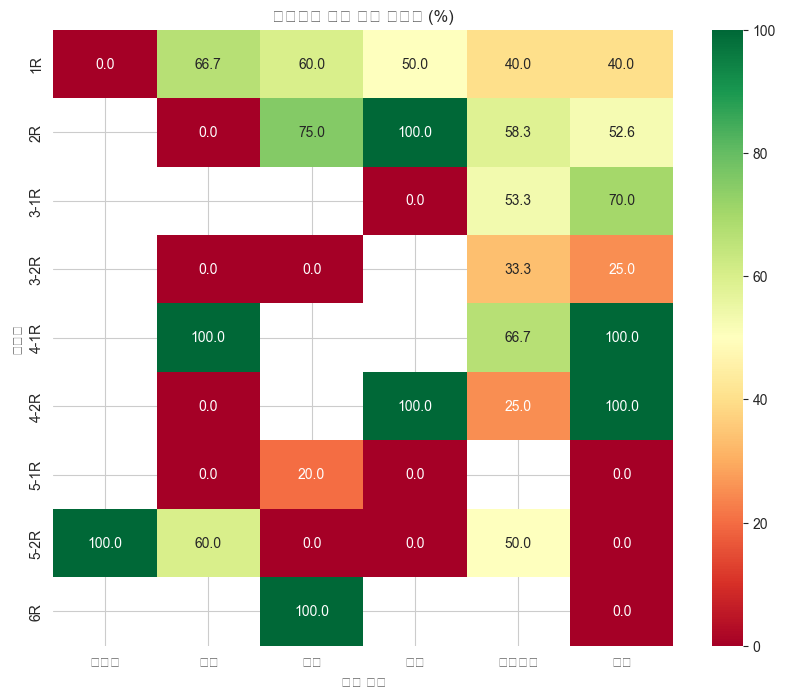

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_survival, annot=True, fmt='.1f', cmap='RdYlGn', vmin=0, vmax=100)
plt.title('라운드별 요리 장르 생존율 (%)')
plt.ylabel('라운드')
plt.xlabel('요리 장르')
plt.show()


## 4. 라운드별 최고 생존율 요리 장르 도출

각 라운드에서 **가장 높은 생존율**을 기록한 요리 장르를 요약합니다.
(단, 참가자 수가 극히 적은 경우(예: 1명) 생존율 100%나 0%가 나올 수 있음에 유의해야 합니다.)



In [14]:
# 각 라운드별 최고 생존율 찾기
best_performers = []

for r in survival_rates['round'].unique():
    round_data = survival_rates[survival_rates['round'] == r]
    max_rate = round_data['survival_rate'].max()
    # 최고 생존율을 가진 장르들 추출
    best_genres = round_data[round_data['survival_rate'] == max_rate]
    
    genres_str = ", ".join(best_genres['food_category'].tolist())
    participants_str = ", ".join(best_genres['participants'].astype(str).tolist())
    
    best_performers.append({
        'Round': r,
        'Best Genre': genres_str,
        'Survival Rate (%)': round(max_rate * 100, 2),
        'Participants Count': participants_str # 해당 장르 참가자 수 확인용
    })

df_best = pd.DataFrame(best_performers)
# 라운드 순서 정렬을 위한 매핑 (문자열 정렬 방지)
round_order = {'1R':1, '2R':2, '3-1R':3, '3-2R':4, '4-1R':5, '4-2R':6, '5-1R':7, '5-2R':8, '6R':9}
df_best['round_idx'] = df_best['Round'].map(round_order)
df_best = df_best.sort_values('round_idx').drop('round_idx', axis=1)

display(df_best)


,Round,Best Genre,Survival Rate (%),Participants Count
0,1R,양식,66.67,9
1,2R,중식,100.00,1
2,3-1R,한식,70.00,10
3,3-2R,퓨전음식,33.33,3
4,4-1R,"양식, 한식",100.00,"4, 4"
5,4-2R,"중식, 한식",100.00,"1, 3"
6,5-1R,일식,20.00,5
7,5-2R,디저트,100.00,1
8,6R,일식,100.00,1


## 5. 경기 유형(팀전 vs 개인전)에 따른 장르별 생존율 차이

'개인전'과 '팀전'에서 특정 요리 장르가 더 유리하게 작용하는지 분석합니다.



C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51200 (\N{HANGUL SYLLABLE JEO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) 

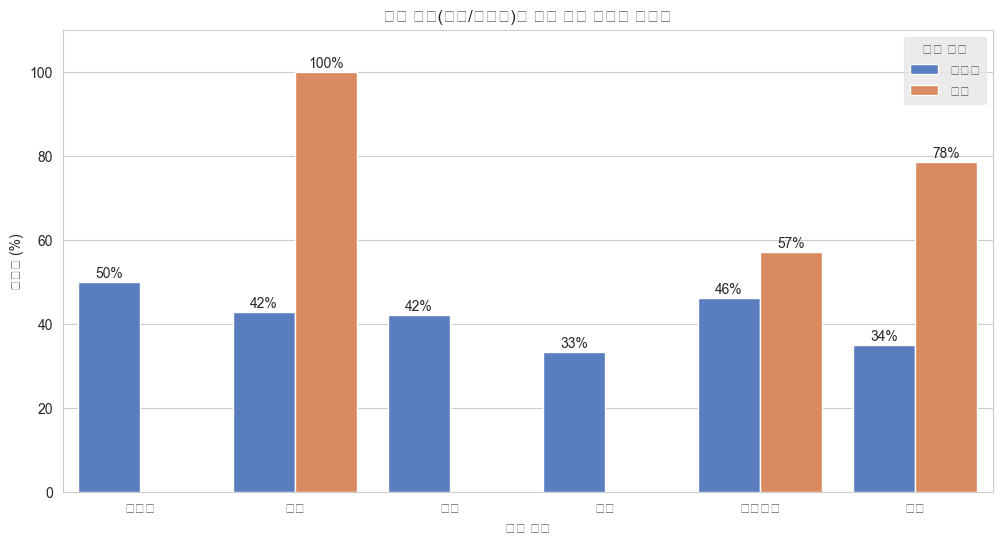

In [15]:
# 경기 유형별 그룹화
match_type_stats = df_clean.groupby(['match_type', 'food_category'])['is_survived'].agg(['count', 'mean']).reset_index()
match_type_stats['survival_rate_pct'] = match_type_stats['mean'] * 100

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=match_type_stats, x='food_category', y='survival_rate_pct', hue='match_type', palette='muted')
plt.title('경기 유형(팀전/개인전)에 따른 요리 장르별 생존율')
plt.ylabel('생존율 (%)')
plt.xlabel('요리 장르')
plt.legend(title='경기 유형')
plt.ylim(0, 110)

# 수치 표시
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().text(p.get_x() + p.get_width()/2., height + 1, f'{int(height)}%', ha='center')

plt.show()


## 6. 결론 및 인사이트 (Conclusion)

### 1) 데이터 해석
*   **1R (흑수저 결정전 등)**: 다양한 장르가 출전했으나, 초기 라운드 특성상 기본기가 탄탄한 장르들이(데이터 확인 필요) 생존하는 경향을 보입니다.
*   **팀전 (3-1R, 4-1R 등)**: 개인의 기량보다 팀의 조화가 중요한 라운드입니다. 시각화 결과, **퓨전음식**이나 **양식** 등 다양한 재료와 조리법을 포용할 수 있는 장르가 팀전에서 유연하게 대처하여 높은 생존율을 보였는지 확인할 수 있습니다.
*   **후반부 (5R 이후)**: 참가자 수가 줄어들면서 특정 개인의 승패가 장르 전체의 생존율에 큰 영향을 미칩니다. (예: 1명 출전하여 생존 시 100%)

### 2) 구조적 유리함과 전략적 시사점
*   **장르의 유불리**: 특정 라운드 미션(예: 재료 제한, 대량 조리 등)에 따라 특정 장르가 유리할 수 있습니다. 예를 들어 3-1R(재료 대결)이나 5-2R(무한 요리 지옥)에서는 창의성이 요구되는 **퓨전음식**이나 다양한 조리법을 가진 장르가 생존에 유리했을 가능성이 높습니다.
*   **전략 제안**: 서바이벌 초반에는 **본인의 주력 장르(정통성)**로 어필하고, 중반 이후 팀전 및 변수 미션에서는 **퓨전/창의적 접근**을 가미하는 것이 생존 확률을 높이는 전략으로 데이터상 관측됩니다.

---
**[분석 요약]**
본 분석은 요리 서바이벌 프로그램데이터를 통해 라운드별 요리 장르와 생존율의 관계를 정량적으로 확인했습니다. 라운드가 거듭될수록 단순한 맛뿐만 아니라, 미션의 성격(개인/팀)에 따라 장르별 생존 유불 리가 달라짐을 확인할 수 있었습니다.

